# Calibrated Housing Price Prediction 

*Use case*: A decision support system to assist real estate investment, by suggesting predicted housing price of a given property. This is a regression task, for which predictive uncertainty is expressed as a prediction interval: an estimated interval in which the true value is expected to fall with a pre-specified probability (e.g., 95%). It could be generated by Gaussian Processes, Bayesian Neural Networks or Bootstrap/Ensemble methods to name a few approaches.

In this example, let us assume that John is a data scientist and takes on the role of the model developer. He trains a Gaussian Process to obtain the estimated house price and the prediction intervals. Ella is a real estate investor, who based on the model's predictions and the uncertainty estimates makes decisions such as investind or selling a property.

Here are the steps involved in the analysis:

#### Step 1: Write import statements.

#### Step 2: Load and pre-process the dataset.

#### Step 3: Train a GP regression model with number of rooms and crime-rate as the features.

#### Step 4: Assess the quality of the prediction intervals.

#### Step 5: Perform recalibration using Uncertainty Characteristic Curve.

#### Step 6: Add an additional feature - education quality to reduce data uncertainty.

#### Step 7: Collect and train use additional data to reduce model uncertainty.

#### Step 8: Communicate the uncertainty to decision makers.

# Step 1: Write import statements.

In [1]:
from importlib import reload
import numpy as np
import torch
import torch.nn as nn
from matplotlib.pyplot import plot, scatter, xlim, legend, title
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append("../../")

In [3]:
from uq360.algorithms.homoscedastic_gaussian_process_regression import HomoscedasticGPRegression
from uq360.algorithms.ucc_recalibration import UCCRecalibration
from uq360.metrics import picp, mpiw, compute_regression_metrics, plot_uncertainty_distribution, plot_uncertainty_by_feature, plot_picp_by_feature
from uq360.metrics.uncertainty_characteristics_curve import UncertaintyCharacteristicsCurve as ucc

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import torch

# Step 2: Load and pre-process the dataset.

In [5]:
# Let us generate sythetic data for 1000 houses.
num_instances = 1000

all_features = ['num_rooms', 'crime_rate', 'education_quality']

# Number of rooms feature has a Gaussian marginal distribution with mean 4 and std 2.
num_rooms = np.clip(np.ceil(10.0 * np.random.rand(num_instances)), 1, 10)

# Crime rate feature is normalized between 0 and 1 has a uniform distribution.
crime_rate = np.random.rand(num_instances)

# Education quality feature is normalized between 0 and 1 has a uniform distribution.
education_quality = np.random.rand(num_instances)

# Let us assume that the house price is a linear function of these features with 
# postive correlation with number of rooms and education quality and negtatice correlation
# with crime rate. Let us also assume the following model for the house prices with homogeneous 
# Gaussian noise with mean=0 and std= 0.2 .

y = 0.1 * num_rooms + 0.5 * education_quality - 0.5 * crime_rate + 1.0 + 0.1 * np.random.randn(num_instances)

# Adjust the house prices (in $1000s) to match the current (2021) average house price in Boston whihch is 665K. 
# Let us scale the mean of the dataset to be 665K.
y = (665.0 / y.mean()) * y

X_full = np.hstack([num_rooms.reshape(-1,1), crime_rate.reshape(-1,1), education_quality.reshape(-1,1)])

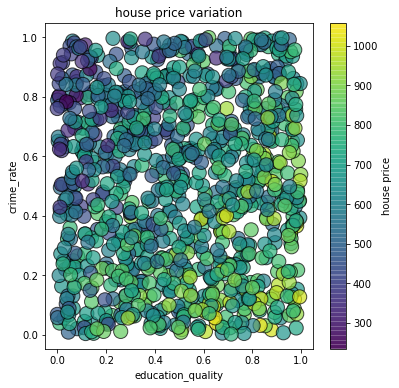

In [7]:
fig = plt.figure(figsize=(6, 6))
sc = plt.scatter(education_quality, crime_rate,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=y)
plt.xlabel("education_quality")
plt.ylabel("crime_rate")
plt.title("house price variation")
cb = plt.colorbar(sc)
cb.set_label("house price")
plt.show()

In [8]:
x_train_full, x_test_full, y_train_full, y_test = train_test_split(X_full, y, test_size=0.3, random_state=0)

Hold out a part of the training dataset for post-hoc calibration.

In [9]:
x_train_full, x_train_calib_full, y_train_full, y_train_calib = train_test_split(x_train_full, y_train_full, test_size=0.3, random_state=0)

x_train_full, y_train_full = x_train_full[x_train_full[:,0]>1], y_train_full[x_train_full[:,0]>1]

John starts out by using the number of rooms and the crime rate in the neighborhood as the input features for the model and the target variable is the house price.

```AGE - proportion of owner-occupied units built prior to 1940
CRIM - per capita crime rate by town```

Lets us simulate a case, where John has partial access to this dataset, by removing 40% instances with rooms >= 6. And John does not have houses in the training set with value greater than 700K.

In [10]:
x_train_keep, x_train_discard, y_train_keep, y_train_discard = train_test_split(x_train_full, y_train_full, test_size=0.9, random_state=0)

idxs = x_train_discard[:,0] < 6
x_train = np.concatenate([x_train_keep, x_train_discard[idxs]])
y_train = np.concatenate([y_train_keep, y_train_discard[idxs]])

idxs = y_train < 700
x_train = x_train[idxs]
y_train = y_train[idxs]

x_train_two_features = x_train[:,:2]
x_test_two_features = x_test_full[:,:2]
x_train_calib_two_features = x_train_calib_full[:,:2]

Text(0.5, 1.0, 'Training data')

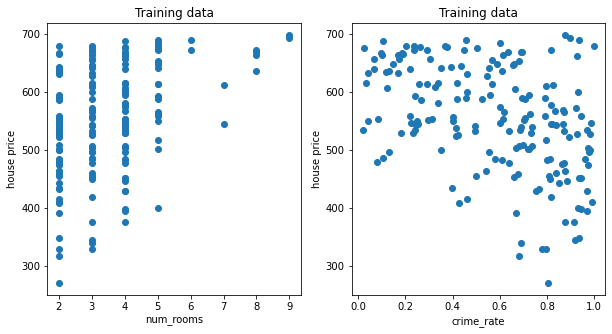

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:,0], y_train)
plt.xlabel(all_features[0])
plt.ylabel('house price')
plt.title('Training data')
plt.subplot(1, 2, 2)
plt.scatter(x_train[:,1], y_train)
plt.xlabel(all_features[1])
plt.ylabel('house price')
plt.title('Training data')

Text(0.5, 1.0, 'Test data')

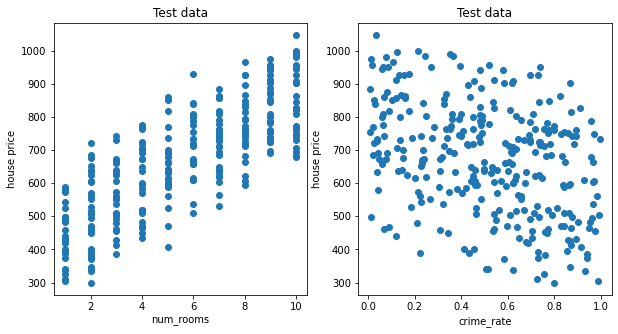

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_test_two_features[:,0], y_test)
plt.xlabel(all_features[0])
plt.ylabel('house price')
plt.title('Test data')
plt.subplot(1, 2, 2)
plt.scatter(x_test_two_features[:,1], y_test)
plt.xlabel(all_features[1])
plt.ylabel('house price')
plt.title('Test data')

# Step 3: Train a GP regression model with number of rooms and crime-rate as the features.

The choice of UQ method depends on several factors. You can read a detailed Guidance on choosing UQ algorithms.  
  
Following the guidance, John recognizes that:  
  
- He would like to train an uncertainty capable model, since he has not built the model yet 
- He would like to capture model uncertainty so the UQ estimation gives him a more complete picture 
- He has a relatively small dataset 
 
Based on these consideration, John chooses to implement Gaussian Process to obtain the prediction interval with 95% confidence as the UQ information for the regression model, that is, to tell where the predicted price can fall with 95% probability. 

In [13]:
gp = HomoscedasticGPRegression()

In [14]:
gp.fit(x_train_two_features, y_train.reshape(-1,1))

#### Obtain mean estimate, prediction interval, and uncertainty distributions on test data and compute several metrics.

In [15]:
y_test_mean, y_test_lower_total, y_test_upper_total, \
y_test_lower_epistemic, y_test_upper_epistemic, y_dists = gp.predict(
                                                        x_test_two_features, return_epistemic=True, return_dists=True)

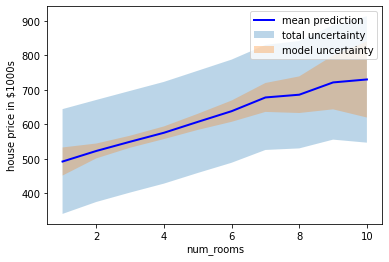

In [16]:
plot_uncertainty_by_feature(x_test_two_features[:, 0], y_test_mean,
                            y_test_lower_total, y_test_upper_total,
                            y_test_lower_epistemic, y_test_upper_epistemic,
                            xlabel=all_features[0], ylabel='house price in $1000s');

# Step 4: Assess the quality of the prediction intervals.

When a UQ method is chosen, it is important to assess its calibration.  Like a model’s prediction performance, the coverage performance, or calibration of a UQ method should also be evaluated with a set of test data. With a well-calibrated UQ method, if it says the prediction interval covers the right price with 95% confidence, then close to 95% or at least a great majority of the test data should fall within the prediction interval. Otherwise the UQ information could be unreliable, and users should not be presented with such information or at least alerted. 
  
To assess the calibration of the UQ method, John uses a metric called Prediction Interval Coverage Probability (PICP), included in UQ360. Formally, PCIP is defined as the fraction of a sample (e.g., test data) covered by the prediction interval.  A well-calibrated UQ method should have a PICP close to the set confidence of the prediction interval (95 % in this case). 
  
The calibration could vary for subsets of the data. UQ360 offers a function to plot PICP by different values of a feature, together with the total PICP for John to look at. Select a feature below and see what John learns. 

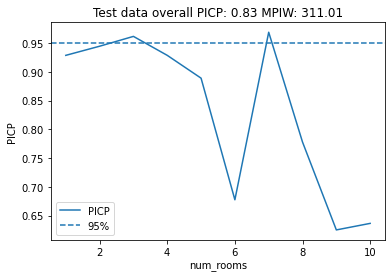

In [17]:
plot_picp_by_feature(x_test_two_features[:, 0], y_test,
                     y_test_lower_total, y_test_upper_total,
                     xlabel=all_features[0]);

John observes that the PICP score drops significantly below the desired confidence 95% for houses with more than  5 rooms. This tells John that the UQ information is miss-calibrated for houses with a larger number of rooms and could be misleading to show to sellers. 

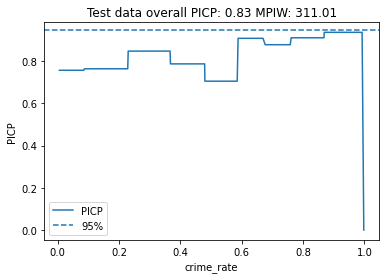

In [19]:
plot_picp_by_feature(x_test_two_features[:, 1], y_test,
                     y_test_lower_total, y_test_upper_total,
                     xlabel=all_features[1]);

In [20]:
res = compute_regression_metrics(y_test, y_test_mean, y_test_lower_total, y_test_upper_total)

In [21]:
res

{'rmse': 108.23064929042266,
 'nll': 6.188613378205094,
 'auucc_gain': 0.05755819810966027,
 'picp': 0.83,
 'mpiw': 311.0143174374187,
 'r2': 0.576919549741453}

### Compute the PICP score for different number rooms.

In [22]:
for num_room in np.unique(x_test_two_features[:,0]):
    coverage = picp(y_test[x_test_two_features[:,0]==num_room], 
             y_test_lower_total[x_test_two_features[:,0]==num_room], 
             y_test_upper_total[x_test_two_features[:,0]==num_room])
    print("coverage for houses with {} rooms {} is ".format(num_room, coverage))

coverage for houses with 1.0 rooms 0.9285714285714286 is 
coverage for houses with 2.0 rooms 0.9444444444444444 is 
coverage for houses with 3.0 rooms 0.9615384615384616 is 
coverage for houses with 4.0 rooms 0.9285714285714286 is 
coverage for houses with 5.0 rooms 0.8888888888888888 is 
coverage for houses with 6.0 rooms 0.6774193548387096 is 
coverage for houses with 7.0 rooms 0.96875 is 
coverage for houses with 8.0 rooms 0.7777777777777778 is 
coverage for houses with 9.0 rooms 0.625 is 
coverage for houses with 10.0 rooms 0.6363636363636364 is 


# Step 5: Perform recalibration using Uncertainty Characteristic Curve.

UQ360 provides several methods for John to improve the calibration of UQ information. John chooses to re-calibrate the prediction interval using Uncertainty Characteristic Curve to improve the PICP score. Then he assesses the calibration again. 

In [23]:
gp_option_a = UCCRecalibration(base_model=gp)
gp_option_a = gp_option_a.fit(x_train_calib_two_features, y_train_calib)
calib_y_test_mean, calib_y_test_lower_total, calib_y_test_upper_total = gp_option_a.predict(x_test_two_features, missrate=0.05)

In [24]:
res_calibratred = compute_regression_metrics(y_test, calib_y_test_mean, calib_y_test_lower_total, calib_y_test_upper_total)

In [25]:
res_calibratred

{'rmse': 108.23064929042266,
 'nll': 6.077937917709324,
 'auucc_gain': 0.0587173646670694,
 'picp': 0.97,
 'mpiw': 396.7859291169387,
 'r2': 0.576919549741453}

In [26]:
for num_room in np.unique(x_test_two_features[:,0]):
    coverage = picp(y_test[x_test_two_features[:,0]==num_room], 
             calib_y_test_lower_total[x_test_two_features[:,0]==num_room], 
             calib_y_test_upper_total[x_test_two_features[:,0]==num_room])
    print("coverage for houses with {} rooms {} is ".format(num_room, coverage))

coverage for houses with 1.0 rooms 1.0 is 
coverage for houses with 2.0 rooms 1.0 is 
coverage for houses with 3.0 rooms 1.0 is 
coverage for houses with 4.0 rooms 0.9642857142857143 is 
coverage for houses with 5.0 rooms 1.0 is 
coverage for houses with 6.0 rooms 0.967741935483871 is 
coverage for houses with 7.0 rooms 1.0 is 
coverage for houses with 8.0 rooms 0.9629629629629629 is 
coverage for houses with 9.0 rooms 0.875 is 
coverage for houses with 10.0 rooms 0.9393939393939394 is 


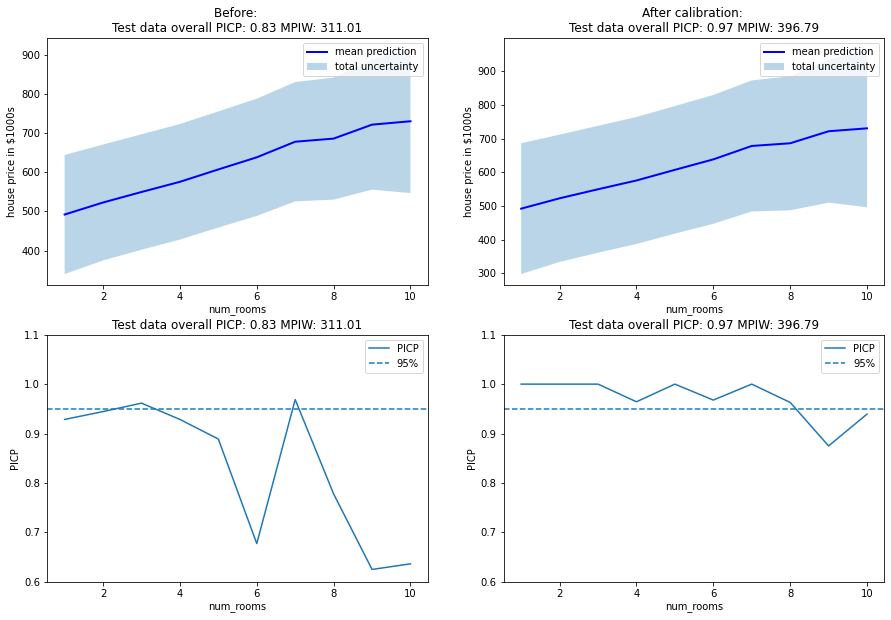

In [27]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

plot_uncertainty_by_feature(x_test_two_features[:, 0], y_test_mean,
                            y_test_lower_total, y_test_upper_total,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,0],
                           title="Before: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                           res["picp"], res["mpiw"]));
plot_uncertainty_by_feature(x_test_two_features[:, 0], y_test_mean,
                            calib_y_test_lower_total, calib_y_test_upper_total,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,1],
                           title="After calibration: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                           res_calibratred["picp"], res_calibratred["mpiw"]));

plot_picp_by_feature(x_test_two_features[:, 0], y_test,
                     y_test_lower_total, y_test_upper_total,
                     xlabel=all_features[0],
                    ax=axs[1,0],
                    ylims=[0.6,1.1]);
plot_picp_by_feature(x_test_two_features[:, 0], y_test,
                     calib_y_test_lower_total, calib_y_test_upper_total,
                     xlabel=all_features[0],
                    ax=axs[1,1],
                    ylims=[0.6,1.1]);

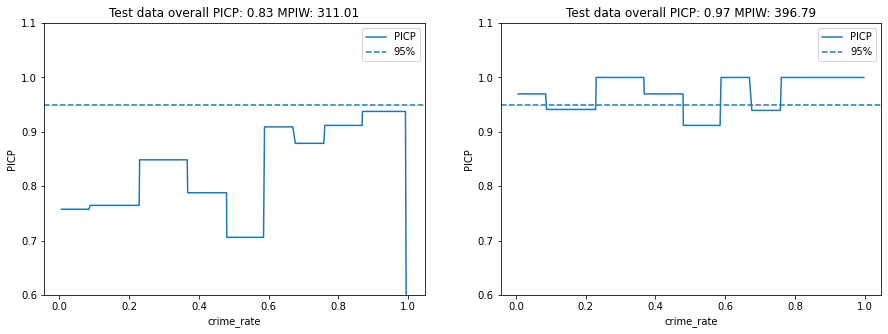

In [29]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

plot_picp_by_feature(x_test_two_features[:, 1], y_test,
                     y_test_lower_total, y_test_upper_total,
                     xlabel=all_features[1],
                    ax=axs[0],
                    ylims=[0.6,1.1]);
plot_picp_by_feature(x_test_two_features[:, 1], y_test,
                     calib_y_test_lower_total, calib_y_test_upper_total,
                     xlabel=all_features[1],
                    ax=axs[1],
                    ylims=[0.6,1.1]);

John observes that the new total PICP is higher than before. Especially for houses with more than 5  rooms, the PICP increased to close to 95% or higher. 

It is worth pointing out that improving calibration does not mean reducing uncertainty. In fact, as a result of the re-calibration, the uncertainty level, captured by a metric called Mean Prediction Interval Width (MPIW), increased. Increased prediction intervals would explicitly tell sellers that the model is less certain about recommended prices as the actual value can fall in a larger range. Sellers can confidently use a recommended price with a prediction interval, though they may still need to rely on their own experience to set an optimal price within that relatively larger interval.  

# Step 6: Add an additional feature - education quality to reduce data uncertainty.

In the longer term, John would like to create a new, improved version of the model that has generally lower uncertainty, i.e. narrower prediction intervals, formally defined as Mean Prediction Interval Width (MPIW), so that sellers could make easier price decisions. 
  
Predictive uncertainty of the model can guide him in this process. With intrinsic UQ methods such as Gaussian Process, predictive uncertainty captures both data uncertainty and model uncertainty. To understand where the uncertainty comes from for a model and how to improve it, it is helpful to examine data uncertainty and model uncertainty separately.

Data uncertainty refers to the random fluctuations between the input features and the outcome in the training data. For example, houses of a similar size or with similar number of rooms could have very different selling prices.  
One way to reduce data uncertainty is by adding new features that could account for the fluctuation. For example, the price differences between two houses with the same number of rooms could be explained by the differences between the neighborhoods they are in, such as available resources for education. 
 
With the old model, John observes that data uncertainty contributes to the total uncertainty (as model uncertainty only accounts for a part of total uncertainty) 
To explore whether the data uncertainty could be reduced, John asks the team to add a new feature to the dataset that could differentiate the neighborhood resources for similar houses: pupil-teacher ratio in a neighborhood (PTRATIO). He then re-trains the model.  

In [30]:
x_train_three_features = x_train
x_test_three_features = x_test_full

In [31]:
gp_expanded = HomoscedasticGPRegression()

In [32]:
gp_expanded.fit(x_train_three_features, y_train.reshape(-1, 1))

In [33]:
y_test_mean_expanded, y_test_lower_total_expanded, y_test_upper_total_expanded, \
    y_test_lower_epistemic_expanded, y_test_upper_epistemic_expanded, y_epistemic_dists_expanded = gp_expanded.predict(
                                                        x_test_three_features, return_epistemic=True, return_epistemic_dists=True)

In [34]:
res_expanded = compute_regression_metrics(y_test, y_test_mean_expanded, y_test_lower_total_expanded, y_test_upper_total_expanded)

In [35]:
res_expanded

{'rmse': 68.31506832352825,
 'nll': 5.608918641161782,
 'auucc_gain': 0.1661835469199717,
 'picp': 0.9033333333333333,
 'mpiw': 205.59826456176097,
 'r2': 0.8314396422967828}

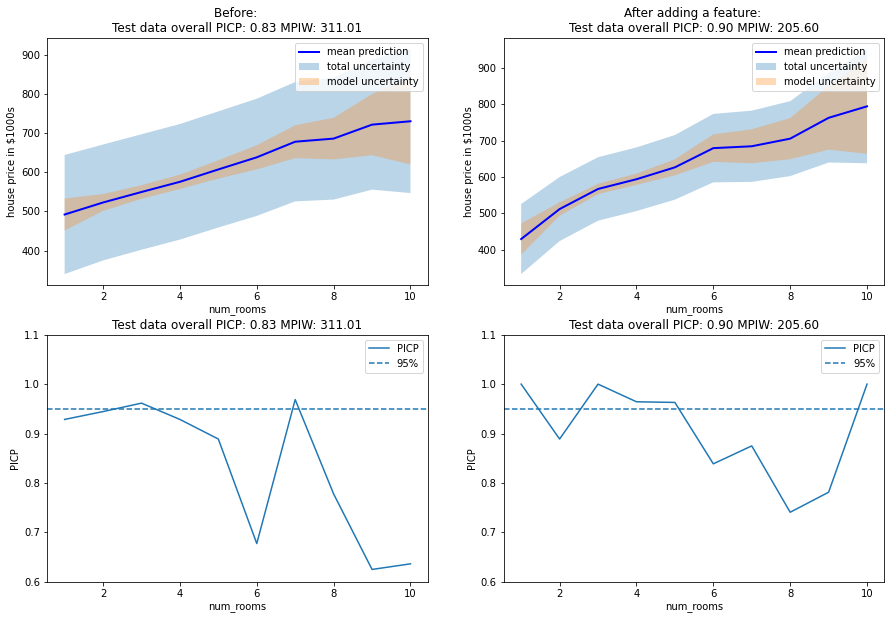

In [36]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plot_uncertainty_by_feature(x_test_two_features[:, 0], y_test_mean,
                            y_test_lower_total, y_test_upper_total,
                            y_test_lower_epistemic, y_test_upper_epistemic,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,0],
                           title="Before: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                           res["picp"], res["mpiw"]));
plot_uncertainty_by_feature(x_test_three_features[:, 0], y_test_mean_expanded,
                            y_test_lower_total_expanded, y_test_upper_total_expanded,
                            y_test_lower_epistemic_expanded, y_test_upper_epistemic_expanded,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,1],
                           title="After adding a feature: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                               res_expanded["picp"], res_expanded["mpiw"]));
plot_picp_by_feature(x_test_two_features[:, 0], y_test,
                     y_test_lower_total, y_test_upper_total,
                     xlabel=all_features[0],
                    ax=axs[1,0],
                    ylims=[0.6,1.1]);
plot_picp_by_feature(x_test_three_features[:, 0], y_test,
                     y_test_lower_total_expanded, y_test_upper_total_expanded,
                     xlabel=all_features[0],
                    ax=axs[1,1],
                    ylims=[0.6,1.1]);

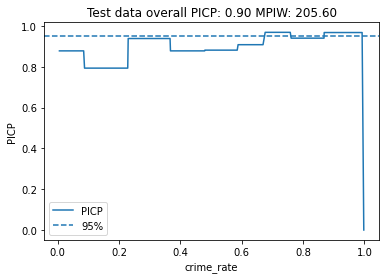

In [38]:
plot_picp_by_feature(x_test_three_features[:, 1], y_test,
                     y_test_lower_total_expanded, y_test_upper_total_expanded,
                     xlabel=all_features[1]);

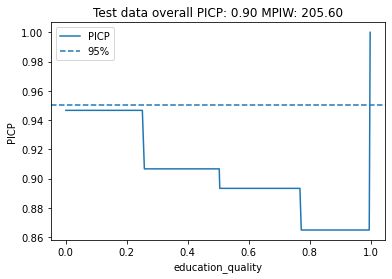

In [40]:
plot_picp_by_feature(x_test_three_features[:, 2], y_test,
                     y_test_lower_total_expanded, y_test_upper_total_expanded,
                     num_bins=5,
                     xlabel=all_features[2]);

In [41]:
for num_room in np.unique(x_test_three_features[:,0]):
    coverage = picp(y_test[x_test_three_features[:,0]==num_room], 
             y_test_lower_total_expanded[x_test_three_features[:,0]==num_room], 
             y_test_upper_total_expanded[x_test_three_features[:,0]==num_room])
    print("coverage for houses with {} rooms {} is ".format(num_room, coverage))

coverage for houses with 1.0 rooms 1.0 is 
coverage for houses with 2.0 rooms 0.8888888888888888 is 
coverage for houses with 3.0 rooms 1.0 is 
coverage for houses with 4.0 rooms 0.9642857142857143 is 
coverage for houses with 5.0 rooms 0.9629629629629629 is 
coverage for houses with 6.0 rooms 0.8387096774193549 is 
coverage for houses with 7.0 rooms 0.875 is 
coverage for houses with 8.0 rooms 0.7407407407407407 is 
coverage for houses with 9.0 rooms 0.78125 is 
coverage for houses with 10.0 rooms 1.0 is 


The additional feature helps him reduce the MPIW.

Next, lets look at the effect of collecting new training samples from the sparsely population regions.

#  Step 7: Collect and train use additional data to reduce model uncertainty.

Model uncertainty arises when multiple model parameter configurations can sufficiently fit the training data. So there is uncertainty in the chosen model configuration, because each alternative configuration would lead to a different prediction. 
In general, model uncertainty can be mitigated by collecting more training data to improve the fitting and filter out alternative model configurations. Examining the detailed model UQ information by different feature-values could guide the data collection choices. 
 
He observes that the predictive intervals for model uncertainty are larger for houses with  more than 5 rooms. This pattern implies that the model has not seen enough examples of houses in that range.  
  
John asks the team to collect more data for houses with more than 5 rooms, then retrains the model. 

In [42]:
# Collecting more data here is equivalent to using the full dataset.
x_train_new, x_train_calib_new, y_train_new, y_train_calib_new = x_train_full, x_train_calib_full, y_train_full, y_train_calib

Text(0.5, 1.0, 'Training data')

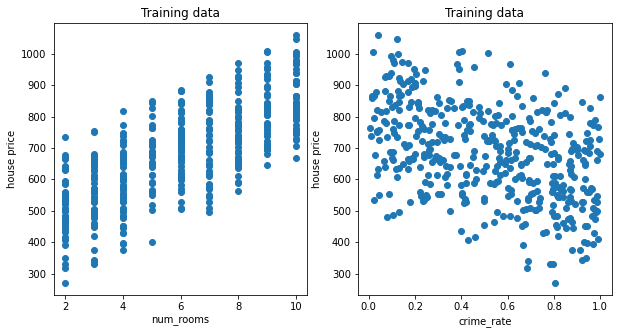

In [43]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train_new[:,0], y_train_new)
plt.xlabel(all_features[0])
plt.ylabel('house price')
plt.title('Training data')
plt.subplot(1, 2, 2)
plt.scatter(x_train_new[:,1], y_train_new)
plt.xlabel(all_features[1])
plt.ylabel('house price')
plt.title('Training data')

In [44]:
gp_new = HomoscedasticGPRegression()

In [45]:
gp_new.fit(x_train_new, y_train_new.reshape(-1,1))

In [46]:
outputs = gp_new.predict(x_test_three_features, return_epistemic=True, return_epistemic_dists=True)
y_test_mean_new = outputs.y_mean
y_test_lower_total_new = outputs.y_lower
y_test_upper_total_new = outputs.y_upper
y_test_lower_epistemic_new = outputs.y_lower_epistemic
y_test_upper_epistemic_new = outputs.y_upper_epistemic
y_epistemic_dists_new = outputs.y_epistemic_dists

In [47]:
res_full = compute_regression_metrics(y_test, y_test_mean_new, y_test_lower_total_new, y_test_upper_total_new)

In [50]:
res_full

{'rmse': 43.338893155181935,
 'nll': 5.190091206086264,
 'auucc_gain': -0.004824937926008787,
 'picp': 0.98,
 'mpiw': 180.1772138457518,
 'r2': 0.9321612149648952}

In [51]:
for num_room in np.unique(x_test_three_features[:,0]):
    coverage = picp(y_test[x_test_three_features[:,0]==num_room], 
             y_test_lower_total_new[x_test_three_features[:,0]==num_room], 
             y_test_upper_total_new[x_test_three_features[:,0]==num_room])
    print("coverage for houses with {} rooms {} is ".format(num_room, coverage))

coverage for houses with 1.0 rooms 1.0 is 
coverage for houses with 2.0 rooms 0.9444444444444444 is 
coverage for houses with 3.0 rooms 1.0 is 
coverage for houses with 4.0 rooms 0.9642857142857143 is 
coverage for houses with 5.0 rooms 0.9629629629629629 is 
coverage for houses with 6.0 rooms 1.0 is 
coverage for houses with 7.0 rooms 0.96875 is 
coverage for houses with 8.0 rooms 1.0 is 
coverage for houses with 9.0 rooms 0.96875 is 
coverage for houses with 10.0 rooms 1.0 is 


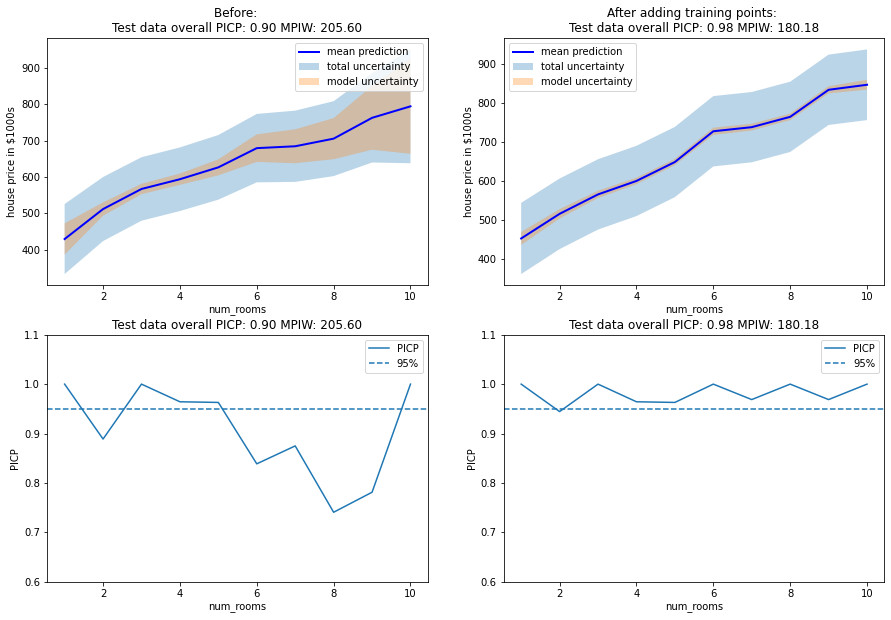

In [52]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plot_uncertainty_by_feature(x_test_three_features[:, 0], y_test_mean_expanded,
                            y_test_lower_total_expanded, y_test_upper_total_expanded,
                            y_test_lower_epistemic_expanded, y_test_upper_epistemic_expanded,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,0],
                           title="Before: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                               res_expanded["picp"], res_expanded["mpiw"]));
plot_uncertainty_by_feature(x_test_three_features[:, 0], y_test_mean_new,
                            y_test_lower_total_new, y_test_upper_total_new,
                            y_test_lower_epistemic_new, y_test_upper_epistemic_new,
                            xlabel=all_features[0], ylabel='house price in $1000s',
                           ax=axs[0,1],
                           title="After adding training points: \nTest data overall PICP: {:.2f} MPIW: {:.2f}".format(
                               res_full["picp"], res_full["mpiw"]))
plot_picp_by_feature(x_test_three_features[:, 0], y_test,
                     y_test_lower_total_expanded, y_test_upper_total_expanded,
                     xlabel=all_features[0],
                    ax=axs[1,0],
                    ylims=[0.6,1.1]);
plot_picp_by_feature(x_test_three_features[:, 0], y_test,
                    y_test_lower_total_new, y_test_upper_total_new,
                    xlabel=all_features[0],
                    ax=axs[1,1],
                    ylims=[0.6,1.1]);

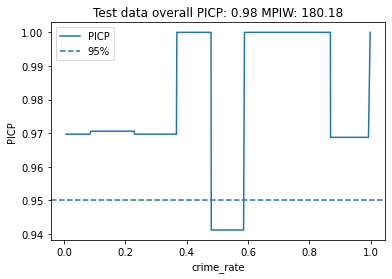

In [54]:
plot_picp_by_feature(x_test_two_features[:, 1], y_test,
                     y_test_lower_total_new, y_test_upper_total_new,
                     xlabel=all_features[1]);

With the new model, the prediction intervals and the overall MPIW narrowed. John is happy about the improvement and approves the new model for sellers to use. 

# Step 8: Communicate the uncertainty to decision makers.

lla uses the AI system to help her set the prices for houses that she puts on a real estate marketplace website. Ella understands that predictions of a ML model involve uncertainty. So she is glad to see that this AI system not only gives a predicted price but also the UQ information—a prediction interval with 95% confidence, that is, to tell her where the price can fall with 95% probability. She is also glad to know that the UQ information has been evaluated for calibration, or coverage performance with test data, so she can confidently rely on the UQ information as an AI suggested price range. 
 
The UQ information of a predicted house price could be communicated to Ella with different levels of precision and in different formats (e.g., verbal, visualization). The plot below demonstrate the followwign communication methods:

- Range of interval (verbal): Easy to read at a glance, but could miss the details of how possible values are distributed in the range.
- Probability density plot: Gives detailed information with a visualization about how possible values are distributed in the prediction interval.
- Quantile dot plot: Shows distribution with a visualization that makes it easier to judge the relative likelihood of where possible values can fall.

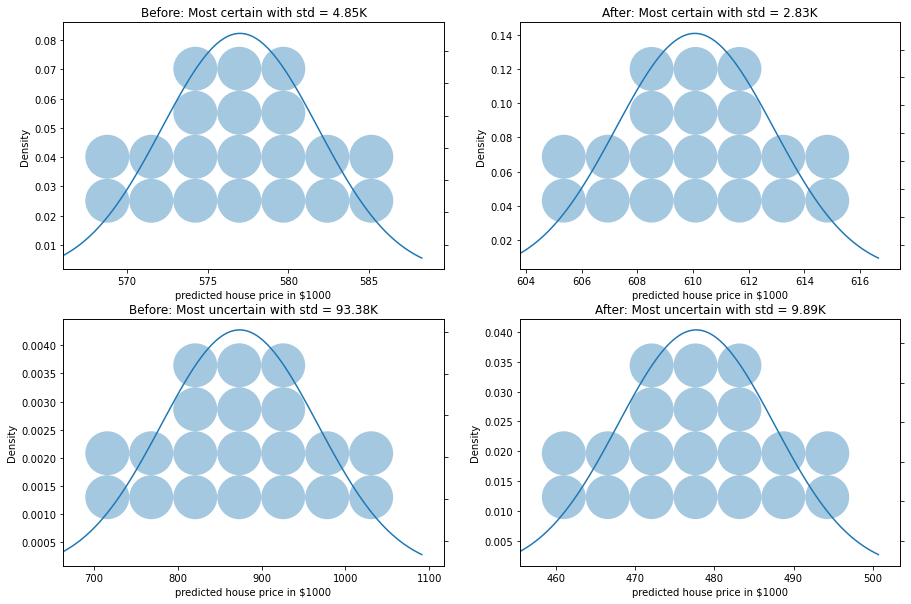

In [55]:
sorted_expanded = np.argsort([dist.std() for dist in y_epistemic_dists_expanded])
sorted_new = np.argsort([dist.std() for dist in y_epistemic_dists_new])
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plot_uncertainty_distribution(y_epistemic_dists_expanded[sorted_expanded[0]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[0,0],
                              #xlims=[500, 1100],
                              xlabel = "predicted house price in $1000",
                             title="Before: Most certain with std = {:.2f}K".format(y_epistemic_dists_expanded[sorted_expanded[0]].std()));
plot_uncertainty_distribution(y_epistemic_dists_expanded[sorted_expanded[-1]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[1,0],
                              #xlims=[500, 1100],
                              xlabel = "predicted house price in $1000",
                             title="Before: Most uncertain with std = {:.2f}K".format(y_epistemic_dists_expanded[sorted_expanded[-1]].std()));
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[0]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[0,1],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000",
                             title="After: Most certain with std = {:.2f}K".format(y_epistemic_dists_new[sorted_new[0]].std()));
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[-1]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[1,1],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000",
                             title="After: Most uncertain with std = {:.2f}K".format(y_epistemic_dists_new[sorted_new[-1]].std()));

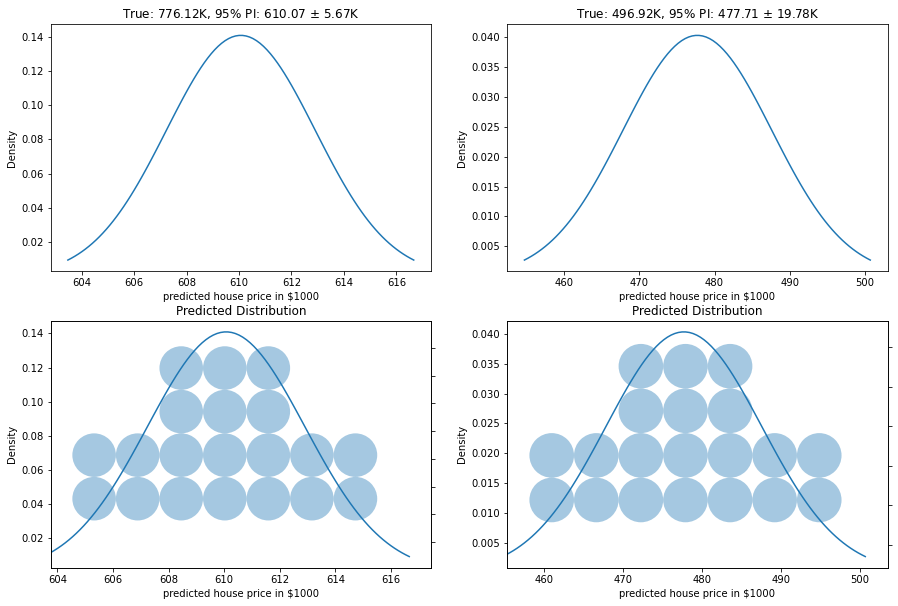

In [56]:
sorted_expanded = np.argsort([dist.std() for dist in y_epistemic_dists_expanded])
sorted_new = np.argsort([dist.std() for dist in y_epistemic_dists_new])
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[0]], show_quantile_dots=False, 
                              qd_sample=20, qd_bins=7, ax=axs[0,0],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000",
                             title=r"True: {:.2f}K, 95% PI: {:.2f} $\pm$ {:.2f}K".format(
                                 y_test[sorted_new[0]],
                                 y_test_mean_new[sorted_new[0]],
                                 2.0 *y_epistemic_dists_new[sorted_new[0]].std())
                             );
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[-1]], show_quantile_dots=False, 
                              qd_sample=20, qd_bins=7, ax=axs[0,1],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000",
                              title=r"True: {:.2f}K, 95% PI: {:.2f} $\pm$ {:.2f}K".format(
                                 y_test[sorted_new[-1]],
                                 y_test_mean_new[sorted_new[-1]],
                                 2.0 *y_epistemic_dists_new[sorted_new[-1]].std())
                             );
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[0]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[1,0],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000");
plot_uncertainty_distribution(y_epistemic_dists_new[sorted_new[-1]], show_quantile_dots=True, 
                              qd_sample=20, qd_bins=7, ax=axs[1,1],
                              #xlims=[400, 700],
                              xlabel = "predicted house price in $1000");

In [57]:
print(r"True: {:.2f}K, 95% PI: {:.2f} $\pm$ {:.2f}K, num_rooms: {:.2f}, crime_rate: {:.2f}, education_quality: {:.2f}".format(
                                 y_test[sorted_new[0]],
                                 y_test_mean_new[sorted_new[0]],
                                 2.0 *y_epistemic_dists_new[sorted_new[0]].std(),
                                 x_test_full[sorted_new[0],0],
                                 x_test_full[sorted_new[0],1],
                                 x_test_full[sorted_new[0],2],
    
))
print(r"True: {:.2f}K, 95% PI: {:.2f} $\pm$ {:.2f}K, num_rooms: {:.2f}, crime_rate: {:.2f}, education_quality: {:.2f}".format(
                                 y_test[sorted_new[-1]],
                                 y_test_mean_new[sorted_new[-1]],
                                 2.0 *y_epistemic_dists_new[sorted_new[-1]].std(),
                                 x_test_full[sorted_new[-1],0],
                                 x_test_full[sorted_new[-1],1],
                                 x_test_full[sorted_new[-1],2],
    
))

True: 776.12K, 95% PI: 610.07 $\pm$ 5.67K, num_rooms: 4.00, crime_rate: 0.48, education_quality: 0.49
True: 496.92K, 95% PI: 477.71 $\pm$ 19.78K, num_rooms: 1.00, crime_rate: 0.01, education_quality: 0.05
